In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset_path = "Multi-class Weather Dataset"
image_size = (180, 180)
batch_size = 32
seed = 1337

# Load dataset in grayscale
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="both",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale"
)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 1083 files belonging to 4 classes.
Using 867 files for training.
Using 216 files for validation.


In [3]:
#making sure any grayscale is changed to rgb
def convert_grayscale_to_rgb(image, label):
    return tf.image.grayscale_to_rgb(image), label

train_ds_rgb = train_ds.map(convert_grayscale_to_rgb)
val_ds_rgb = val_ds.map(convert_grayscale_to_rgb)

AUTOTUNE = tf.data.AUTOTUNE
train_ds_rgb = train_ds_rgb.prefetch(AUTOTUNE)
val_ds_rgb = val_ds_rgb.prefetch(AUTOTUNE)

In [4]:
base_model = keras.applications.DenseNet121(
    input_shape=image_size + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # Freeze the convolutional base

model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=image_size + (3,)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
history = model.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=10
)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 517ms/step - accuracy: 0.3426 - loss: 1.5933 - val_accuracy: 0.4259 - val_loss: 1.3023
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 480ms/step - accuracy: 0.4268 - loss: 1.2953 - val_accuracy: 0.5509 - val_loss: 1.0922
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 497ms/step - accuracy: 0.5467 - loss: 1.0857 - val_accuracy: 0.5926 - val_loss: 0.9771
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 497ms/step - accuracy: 0.6021 - loss: 0.9725 - val_accuracy: 0.6435 - val_loss: 0.8957
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 500ms/step - accuracy: 0.6378 - loss: 0.8887 - val_accuracy: 0.6528 - val_loss: 0.8460
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 512ms/step - accuracy: 0.6528 - loss: 0.8270 - val_accuracy: 0.6898 - val_loss: 0.7994
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 513ms/step - accuracy: 0.7013 - loss: 0.7717 - val_accuracy: 0.6991 - val_loss: 0.7578
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 524ms/step - accuracy: 0.7347 - loss: 0.7067 - val_accu

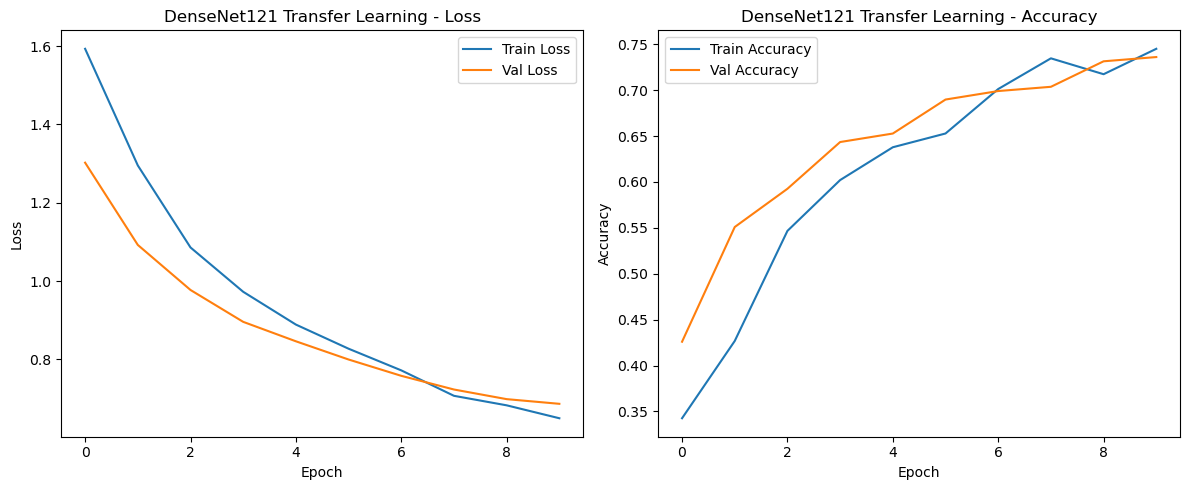

In [6]:
def plot_learning_curves(history, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history, "DenseNet121 Transfer Learning")

In [7]:
model.save("DenseNet121_Weather.keras")